## Вводная
Так как датасет цифр mnist на реальных данных показал точность около 50%, пришлось создавать свой датасет.

## Импорты

In [57]:
%matplotlib inline
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import gzip
import zipfile
import struct
import pickle
try:
    from PIL import Image
except ImportError:
    import Image
    
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf

## Загрузка данных

In [37]:
data_folder = os.path.join(os.getcwd(), '../data/cfu')
os.makedirs(data_folder, exist_ok=True)

In [38]:
urllib.request.urlretrieve('https://cfuvbot.ru/media/datasets/images.npy',
                           filename=os.path.join(data_folder, 'images.npy'))
urllib.request.urlretrieve('https://cfuvbot.ru/media/datasets/targets.npy',
                           filename=os.path.join(data_folder, 'targets.npy'))

('/home/alexstr/Dev/data_science_diplom/notebooks/../data/cfu/targets.npy',
 <http.client.HTTPMessage at 0x7f4eac7ded30>)

In [39]:
images = np.load('../data/cfu/images.npy')
targets = np.load('../data/cfu/targets.npy')

In [40]:
print(images.shape)
targets.shape

(5388, 784)


(5388,)

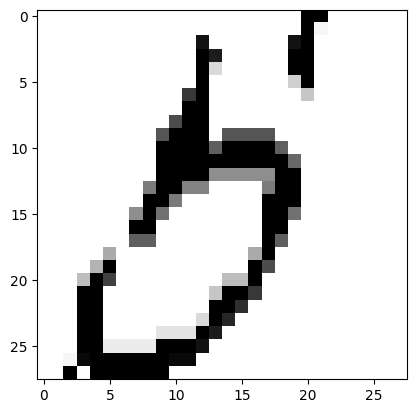

5.0

In [41]:
plotting = plt.imshow(images[234].reshape(28, 28),cmap='gray_r')
plt.show()
targets[234]

## Обработка данных

In [42]:
X_train = images[:5000]
X_test = images[5000:]
y_train = targets[:5000]
y_test = targets[5000:]

In [45]:
X_test.shape

(388, 784)

Предобработка данных для обучения нейронки

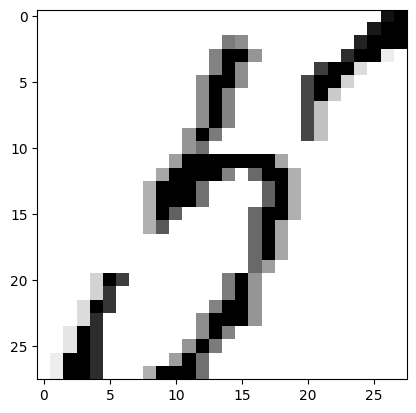

In [46]:
X_nn_train = X_train.reshape(5000, 28, 28)
X_nn_test = X_test.reshape(388, 28, 28)
plotting = plt.imshow(X_nn_train[0], cmap='gray_r')
plt.show()

Разработка модели

In [47]:
k_neibors = KNeighborsClassifier()
param_grid_neibors = {'n_neighbors': [5, 10, 15, 30]}
best_k_neibors = GridSearchCV(k_neibors, param_grid_neibors)

best_k_neibors.fit(X_train, y_train)
best_k_neibors_pred = best_k_neibors.predict(X_test)
print(f"The model is {accuracy_score(best_k_neibors_pred, y_test)*100}% accurate")

The model is 90.20618556701031% accurate


In [48]:
model_folder = os.path.join(os.getcwd(), '../models/cfu')
os.makedirs(model_folder, exist_ok=True)

filename = '../models/cfu/k_neibors_model.sav'
pickle.dump(best_k_neibors, open(filename, 'wb'))

In [49]:
forest = RandomForestClassifier()
param_grid_forest = {
    'n_estimators': [10, 20, 50],
    'random_state': [0, 5, 20, 40]
}
best_forest = GridSearchCV(forest, param_grid_forest)
best_forest.fit(X_train, y_train)
best_forest_pred = best_forest.predict(X_test)
print(f"The model is {accuracy_score(best_forest_pred, y_test)*100}% accurate")

The model is 90.20618556701031% accurate


In [50]:
model_folder = os.path.join(os.getcwd(), '../models/cfu')
os.makedirs(model_folder, exist_ok=True)

filename = '../models/cfu/forest_model.sav'
pickle.dump(best_forest, open(filename, 'wb'))

In [54]:
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc_with_grid_search = svm.SVC(probability=True)
best_svc = GridSearchCV(svc_with_grid_search, param_grid)
best_svc.fit(X_train, y_train)
best_svc_pred = best_svc.predict(X_test)
print(f"The model is {accuracy_score(best_svc_pred, y_test)*100}% accurate")

The model is 92.78350515463917% accurate


In [55]:
model_folder = os.path.join(os.getcwd(), '../models/cfu')
os.makedirs(model_folder, exist_ok=True)

filename = '../models/cfu/svc_model.sav'
pickle.dump(best_svc, open(filename, 'wb'))

In [58]:
print(
    f"Classification report for classifier {best_svc}:\n"
    f"{metrics.classification_report(y_test, best_svc_pred)}\n"
)

Classification report for classifier GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['rbf', 'poly']}):
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96        69
         1.0       0.97      0.94      0.96        34
         2.0       0.93      0.94      0.93        79
         3.0       0.87      0.85      0.86        48
         4.0       0.93      0.93      0.93        58
         5.0       0.93      0.93      0.93        59
         6.0       0.88      0.93      0.90        41

    accuracy                           0.93       388
   macro avg       0.93      0.93      0.93       388
weighted avg       0.93      0.93      0.93       388




In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
model.fit(X_nn_train, y_train, epochs=50, validation_split=0.3)

test_loss, test_acc = model.evaluate(X_nn_test,  y_test, verbose=0)

print('Точность на тестовом множестве:', test_acc)

Epoch 1/50
110/110 [==============================] - 1s 4ms/step - loss: 1.0814 - accuracy: 0.6380 - val_loss: 0.7478 - val_accuracy: 0.7487
Epoch 2/50
110/110 [==============================] - 0s 3ms/step - loss: 0.4662 - accuracy: 0.8609 - val_loss: 0.5282 - val_accuracy: 0.8460
Epoch 3/50
110/110 [==============================] - 0s 3ms/step - loss: 0.2590 - accuracy: 0.9266 - val_loss: 0.4728 - val_accuracy: 0.8473
Epoch 4/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1485 - accuracy: 0.9631 - val_loss: 0.4143 - val_accuracy: 0.8713
Epoch 5/50
110/110 [==============================] - 0s 3ms/step - loss: 0.0903 - accuracy: 0.9826 - val_loss: 0.3957 - val_accuracy: 0.8700
Epoch 6/50
110/110 [==============================] - 0s 3ms/step - loss: 0.0531 - accuracy: 0.9923 - val_loss: 0.4966 - val_accuracy: 0.8527
Epoch 7/50
110/110 [==============================] - 0s 3ms/step - loss: 0.0281 - accuracy: 0.9963 - val_loss: 0.3711 - val_accuracy: 0.8840
Epoch 

In [59]:
model.save('../models/cfu/nn_model.h5', save_format="h5")

In [60]:
loaded_model = tf.keras.models.load_model('../models/cfu/nn_model.h5')

In [66]:
probability_model = tf.keras.Sequential([loaded_model, 
                                         tf.keras.layers.Softmax()])


In [84]:
test_image = np.array([X_nn_test[84]])
test_image.shape

(1, 28, 28)

In [85]:
predictions = probability_model.predict(test_image)
np.argmax(predictions[0])



1/1 [==============================] - 0s 14ms/step


6

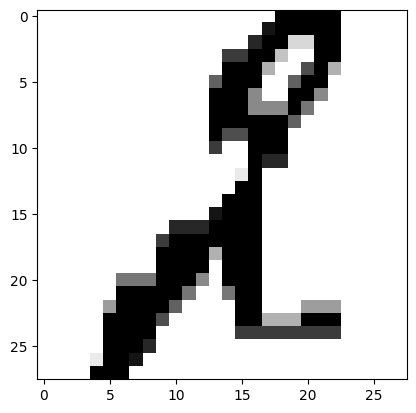

In [86]:
plotting = plt.imshow(X_nn_train[84], cmap='gray_r')
plt.show()

In [87]:
y_train[84]

2.0